# Inspect and index patterns

Håkon Wiik Ånes (hakon.w.anes@ntnu.no), 2023-02-11

Load necessary libraries

In [1]:
%matplotlib qt5

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix import io, plot, sampling
from orix.crystal_map import PhaseList
from orix.vector import Vector3d


# Matplotlib parameters
savefig_kw = dict(bbox_inches="tight", pad_inches=0, dpi=200)

# File paths
dir_data = Path(r"D:\Master_thesis\EBSD\Hugo\M\1")
dir_nordif = dir_data / "nordif"
dir_kp = dir_data / "kp"

Print library versions (these versions are most likely required to run this notebook without issue)

In [2]:
from datetime import date
import importlib_metadata

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in ["diffsims", "hyperspy", "kikuchipy", "matplotlib", "numpy", "orix", "PyQt5"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2023-04-02

Software versions
------------------
diffsims : 0.5.1
hyperspy : 1.7.3
kikuchipy : 0.8.0
matplotlib : 3.6.3
numpy : 1.23.5
orix : 0.11.0
PyQt5 : 5.15.7


## Load and inspect raw data

Load data (for larger datasets, `lazy=True` can be used to reduce memory use, see https://hyperspy.org/hyperspy-doc/current/user_guide/big_data.html)

In [3]:
s = kp.load(dir_data / "Pattern.dat", lazy=False)
s.xmap.scan_unit = "um"
s

2023-04-02 15:24:14,076 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


<EBSD, title: Pattern, dimensions: (375, 342|96, 96)>

Inspect pattern quality without background correction and potential features in the map (see visualization tutorial https://kikuchipy.org/en/stable/tutorials/visualizing_patterns.html).

The marker is red and starts in the upper left corner: you might have to press "+" many times to be able to click inside it and navigate around.

In [4]:
s.plot()

In [5]:
roi = hs.roi.RectangularROI(left=0, top=0, right=10, bottom=10)
s.plot_virtual_bse_intensity(roi)

Get an indexing-independent view of the data via virtual backscatter electron imaging (see tutorial for details and references https://kikuchipy.org/en/stable/tutorials/virtual_backscatter_electron_imaging.html).

In [6]:
vbse_imager = kp.imaging.VirtualBSEImager(s)
print(vbse_imager.grid_shape)
print(vbse_imager)

(5, 5)
VirtualBSEImager for <EBSD, title: Pattern, dimensions: (375, 342|96, 96)>


Get virtual backscatter electron images from the (5, 5) grid on the detector

In [7]:
vbse_imgs = vbse_imager.get_images_from_grid()

In [8]:
_ = hs.plot.plot_images(vbse_imgs, per_row=5, axes_decor=None, colorbar=None)

We see that the intensities in the top part of the detector show mostly topographic contrast, while the center row shows more atomic number (Z) contrast.
We'll get one VBSE image each of these rows

In [9]:
vbse_img_top = vbse_imgs.inav[:, 0].sum(0)  # All columns, first row -> sum along row
vbse_img_center = vbse_imgs.inav[:, 2].sum(0)

Inspect the images: Holes on the sample surface are dark (topography) while particles are brighter (higher Z) because they contain heavier elements than Al (like Mn, Fe and Si) and thus scatter more BSEs

In [10]:
vbse_img_top.plot()

In [11]:
vbse_img_center.plot()

We will use these intensities to exclude incorrectly indexed points at the end, so we save the maps as images

In [14]:
plt.imsave(dir_kp / "maps_vbse_top.png", vbse_img_top.data, cmap="gray")
plt.imsave(dir_kp / "maps_vbse_center.png", vbse_img_center.data, cmap="gray")

We'll also save the images with a nice scalebar (using the `CrystalMap` to the signal [as an attribute](https://kikuchipy.org/en/stable/reference/generated/kikuchipy.signals.EBSD.xmap.html#kikuchipy.signals.EBSD.xmap))

In [15]:
fig = s.xmap.plot(vbse_img_top.data.ravel(), return_figure=True, remove_padding=True)
fig.savefig(dir_kp / "maps_vbse_top_colorbar.png", **savefig_kw)

In [16]:
fig = s.xmap.plot(vbse_img_center.data.ravel(), return_figure=True, remove_padding=True)
fig.savefig(dir_kp / "maps_vbse_center_colorbar.png", **savefig_kw)

Due to the topography, VBSEs are dominated by this contrast.
But, we could try to get an orientation contrast image as well.
We do this by coloring three center tiles red-green-blue, after changing the grid shape to (3, 3)

In [17]:
vbse_imager.grid_shape = (3, 3)
_ = vbse_imager.plot_grid()

Get RGB image from some grid tiles

In [18]:
vbse_rgb_img = vbse_imager.get_rgb_image(r=(1, 0), g=(1, 1), b=(1, 2))

Navigate in patterns with RGB image

In [19]:
s.plot(vbse_rgb_img)

Save RGB image

In [20]:
vbse_rgb_img.change_dtype("uint8")
vbse_rgb_data1d = vbse_rgb_img.data.reshape(-1, 3)
vbse_rgb_img.change_dtype("rgb8")

fig = s.xmap.plot(vbse_rgb_data1d, return_figure=True, remove_padding=True)
fig.savefig(dir_kp / "maps_vbse_rgb.png", **savefig_kw)

## Enhance Kikuchi pattern

Now remove the static and dynamic background (see pattern processing tutorial for details and references https://kikuchipy.org/en/stable/tutorials/pattern_processing.html)

In [21]:
s.remove_static_background()

[########################################] | 100% Completed | 7.40 ss


In [22]:
s.remove_dynamic_background()

[########################################] | 100% Completed | 54.00 s


Can also average with nearest neighbours to increase signal-to-noise (S/N) ratio, but this might give reduced spatial resolution (overlap at phase/grain boundaries etc.)

In [23]:
w = kp.filters.Window("gaussian", std=1)
fig = w.plot(return_figure=True)
fig.savefig(dir_kp / "averaging_kernel.png", **savefig_kw)

In [24]:
s.average_neighbour_patterns(w)

Save patterns to an HDF5 file (see load/save tutorial https://kikuchipy.org/en/stable/tutorials/load_save_data.html#kikuchipy-h5ebsd) to avoid having to do these operations more than once (`s` = static, `d` = dynamic, `a` = averaging)

In [25]:
#s.save(dir_kp / "patterns_sd.h5")
s.save(dir_kp / "patterns_sda.h5")

Can also save to NORDIF's binary pattern format in order to re-index with EDAX TSL DC v7.2 (remember to *not* do static and dynamic background correction again!).
This is only useful if averaging was also done.

In [26]:
#s = kp.load(dir_kp / "Pattern_sda.dat")

## Inspect processed data

Might start from this point later on (you can then skip the two preceding sections)

In [27]:
#s = kp.load(dir_kp / "patterns_sd.h5")
s = kp.load(dir_kp / "patterns_sda.h5")

Get feature maps (image quality and average dot product maps, see tutorial for details and references https://kikuchipy.org/en/stable/tutorials/feature_maps.html).

Get map showing pattern sharpness

In [28]:
iq = s.get_image_quality()

[########################################] | 100% Completed | 17.86 s


Save map

In [29]:
fig = s.xmap.plot(iq.ravel(), cmap="gray", colorbar=True, colorbar_label="Image quality", remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_iq.png", **savefig_kw)

Inspect patterns in this map

In [30]:
s.plot(hs.signals.Signal2D(iq))

Get map showing similarity between each pattern and its four nearest neighbours

In [31]:
adp = s.get_average_neighbour_dot_product_map()

[########################################] | 100% Completed | 119.41 s


Save map

In [32]:
fig = s.xmap.plot(adp.ravel(), cmap="gray", colorbar=True, colorbar_label="Average dot product", remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_adp.png", **savefig_kw)

Inspect patterns in this map

In [33]:
s.plot(hs.signals.Signal2D(adp))

## Calibrate detector-sample geometry

Determine a mean projection/pattern center (PC) and extrapolate this to get one PC per map point.
See e.g. the [Hough indexing tutorial](https://kikuchipy.org/en/stable/tutorials/hough_indexing.html) for all details.
We estimate the mean PC from the Al calibration patterns

In [34]:
s_cal = kp.load(dir_data / "Setting.txt")
s_cal

<EBSD, title: Calibration patterns, dimensions: (5|160, 160)>

In [35]:
s_cal.remove_static_background()
s_cal.remove_dynamic_background()

[########################################] | 100% Completed | 106.05 ms
[########################################] | 100% Completed | 110.29 ms


In [36]:
s_cal.plot(navigator=None)

Get a nice figure showing the sample positions of each calibration pattern

In [37]:
omd = s_cal.original_metadata

In [38]:
fig = kp.draw.plot_pattern_positions_in_map(
    rc=omd.calibration_patterns.indices_scaled,
    roi_shape=omd.roi.shape_scaled,
    roi_origin=omd.roi.origin_scaled,
    area_shape=omd.area.shape_scaled,
    area_image=omd.area_image,
    return_figure=True
)
fig.axes[0].axis("off")
fig.savefig(dir_kp / "calibration_pattern_positions.png", **savefig_kw)

We'll estimate PCs using Hough indexing from [PyEBSDIndex](https://pyebsdindex.readthedocs.io).
We need an `EBSDIndexer` instance, which is simplest to get from [EBSDDetector.get_indexer()](https://kikuchipy.org/en/stable/reference/generated/kikuchipy.detectors.EBSDDetector.get_indexer.html).
To get this indexer, we need a detector and a phase list.

The phase list will only contain one phase, Al, which we can get from scratch (see Hough indexing tutorial) or from a dynamically simulated master pattern.
We'll (down)load the Al master pattern [from Zenodo](https://zenodo.org/record/7628365#.Y-ivwxzMKV4) via the `data` module to your local cache (on my Linux machine it's located in `/home/hakon/.cache/kikuchipy/0.8.0/ebsd_master_pattern/al_mc_mp_20kv.h5`, you can check the cache location by running `import pooch; pooch.os_cache("kikuchipy")`).

You have to set `allow_download=True` yourself (I don't want to surprise-download 200 MB to your computer)!

In [39]:
mp = kp.data.ebsd_master_pattern("al", projection="lambert", energy=20, allow_download=True)
mp.phase.name = "al"

phase_list = PhaseList(mp.phase)

Get indexer

In [40]:
det_cal = s_cal.detector
indexer = det_cal.get_indexer(phase_list)

indexer.phaselist

['FCC']

Only use the Al patterns (exclude the particle pattern)

In [41]:
al_idx = [0, 1,2, 3, 4]

Estimate PC from all patterns, show mean and standard deviation from the Al patterns (I encountered a kernel crash running the following cell... Don't know why. If you do, please let me know!)

In [42]:
det_cal = s_cal.hough_indexing_optimize_pc(
    pc0=[0.5, 0.2, 0.55], indexer=indexer, batch=True,
)

print(det_cal.pc_flattened[al_idx].mean(axis=0))
print(det_cal.pc_flattened[al_idx].std(0))

[0.49874052 0.2169082  0.55874829]
[0.02159905 0.01381245 0.0218379 ]


Compare PC positions to sample positions in the above saved figure

In [43]:
det_cal.plot_pc("scatter", annotate=True)

Quite scattered... This is why we will only use the mean PC and not try to fit a plane to these PCs (will not work since they do not align nicely with the sample positions).

Evaluate the estimated PCs by comparing geometrical simulations to the calibration patterns.
We will: (1) index the patterns, (2) create a list of reflectors, (3) use the reflectors, detector with PCs and indexed solutions to get geometrical simulations, (4) plot these simulations on top of the patterns.

Index the patterns using our estimated PCS

In [44]:
indexer.PC = det_cal.pc
xmap_cal = s_cal.hough_indexing(
    phase_list=phase_list, indexer=indexer, verbose=2
)

Hough indexing with PyEBSDIndex information:
  GPU: True
  Projection center (mean): (0.4987, 0.2169, 0.5587)
  Indexing 5 pattern(s) in 1 chunk(s)
Radon Time: 0.015944600000011633
Convolution Time: 0.0034014999999953943
Peak ID Time: 0.0013191000000460917
Band Label Time: 0.03774799999996503
Total Band Find Time: 0.05843500000003132
Band Vote Time:  0.08196409999993648
  Indexing speed: 29.37200 patterns/s


Create a list of reflectors (see [geometrical simulations tutorial](https://kikuchipy.org/en/stable/tutorials/geometrical_ebsd_simulations.html) for details)

In [45]:
rlv = ReciprocalLatticeVector.from_min_dspacing(mp.phase.deepcopy(), 0.07)
rlv.sanitise_phase()  # "Fill atoms in unit cell"
rlv.calculate_structure_factor()
structure_factor = abs(rlv.structure_factor)
rlv = rlv[structure_factor > 0.17 * structure_factor.max()]
rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    0.233     0.3      0.1      100.0      8   
 2 0 0    0.202     0.2      0.0       64.5      6   
 2 2 0    0.143     0.1      0.0       13.1      12  
 3 1 1    0.122     0.1      0.0       4.0       24  


Create a simulator

In [46]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)

Plot simulator in stereographic projection and highlight the fundamental sector

In [47]:
fig = simulator.plot(return_figure=True)
fig.axes[0].plot(rlv.phase.point_group.fundamental_sector.edges, color="r", zorder=5)
fig.savefig(dir_kp / "geometrical_simulation_al.png", **savefig_kw)

Project parts of this simulation onto our detector for each indexed solution (our geometrical simulations)

In [48]:
sim_cal = simulator.on_detector(det_cal, xmap_cal.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 112.42 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 103.56 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 115.85 ms


Plot patterns and simulations on top

In [49]:
fig, axes = plt.subplots(ncols=5, figsize=(16, 3.5))
for i in range(xmap_cal.size):
    axes[i].imshow(s_cal.inav[i].data, cmap="gray")
    axes[i].add_collection(sim_cal.as_collections(i)[0])
    axes[i].axis("off")
fig.tight_layout()

Refine these solutions using our dynamical simulation

In [50]:
xmap_cal_ref, det_cal_ref = s_cal.refine_orientation_projection_center(
    xmap=xmap_cal,
    detector=det_cal,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.05, 0.05, 0.05],  # Sufficiently wide
    # One pattern per iteration to utilize all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.   5.   5.   0.05 0.05 0.05]
  Relative tolerance: 0.0001
Refining 5 orientation(s) and projection center(s):
[########################################] | 100% Completed | 1.30 sms
Refinement speed: 3.82870 patterns/s


Check the similarity between highest experimental and simulated patterns (clearly lowest for the non-Al pattern!)

In [51]:
print(xmap_cal_ref.scores)

[0.29820234 0.11341853 0.03652979 0.39677453 0.4339498 ]


Evaluate the new solutions by comparing new geometrical simulations (old are red, new are white)

In [52]:
sim_cal_ref = simulator.on_detector(det_cal_ref, xmap_cal_ref.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 108.18 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 103.33 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 116.13 ms


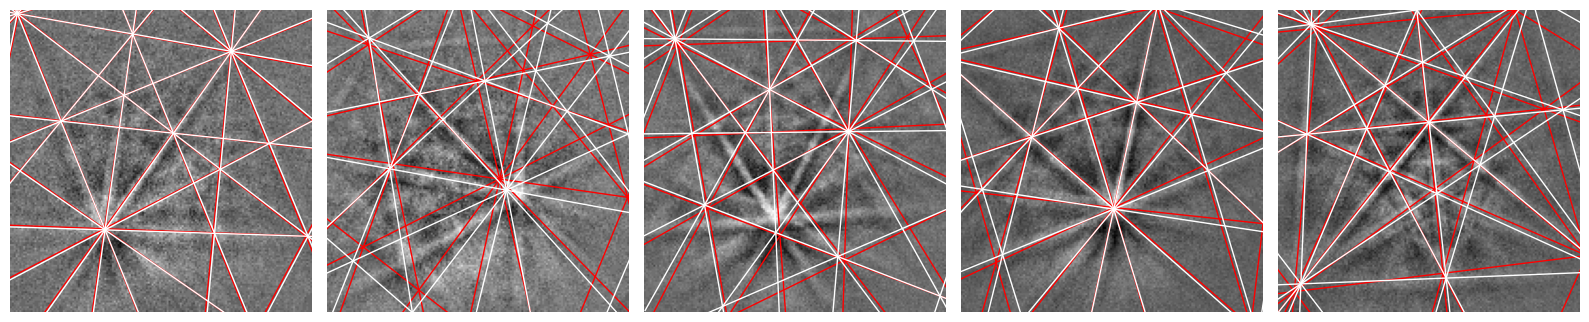

In [53]:
for i in range(xmap_cal_ref.size):
    lines = sim_cal_ref.as_collections(i, lines_kwargs=dict(color="w"))[0]
    axes[i].add_collection(lines)
fig

Check refined PCs

In [54]:
det_cal.plot_pc("scatter", annotate=True)

We still cannot recognize the sample positions in the (PCx, PCy) plot...

We'll use the mean PC from the four Al patterns and extrapolate a plane to get PCs for all map points.
It's important to note that we need to know the detector pixel size to extrapolate the PCs.
The NORDIF UF-1100 detector has (480, 480) pixels unbinned, which each are 70 microns.

Get the sample positions of the five calibration patterns

In [55]:
pc_indices = omd.calibration_patterns.indices_scaled
pc_indices -= omd.roi.origin_scaled
pc_indices = pc_indices.T

Mark the particle pattern as an outlier

In [56]:
is_outlier = np.zeros(det_cal_ref.navigation_size, dtype=bool)
is_outlier[[3]] = True

Extrapolate a plane of PCs

In [57]:
det_cal_fit = det_cal_ref.extrapolate_pc(
    pc_indices=pc_indices,
    navigation_shape=s.xmap.shape,
    step_sizes=[a.scale for a in s.axes_manager.navigation_axes][::-1],
    px_size=70,
    binning=5,
    is_outlier=is_outlier,
)

print(det_cal_fit.pc_average)

[0.49582697 0.2275018  0.5850753 ]


Plot this plane

In [58]:
det_cal_fit.plot_pc("map")

Save the detector plane for later use

In [59]:
det_cal_fit.save(dir_kp / "detector.txt")

## Hough indexing of all patterns

Re-load detector if necessary

In [60]:
det = kp.detectors.EBSDDetector.load(dir_kp / "detector.txt")
det

EBSDDetector (160, 160), px_size 70.0 um, binning 5, tilt 0.0, azimuthal 0.0, pc (0.496, 0.228, 0.585)

Update the detector shape to the one for the experimental (acquisition) patterns

In [61]:
det.shape = s.detector.shape

Get a new indexer

In [62]:
indexer = det.get_indexer(phase_list)

Hough index all patterns (using the GPU, which is available if we have the `pyopencl` package available, try `conda install pyopencl` or `pip install pyopencl` if not)

In [63]:
xmap_hi = s.hough_indexing(phase_list, indexer=indexer, verbose=2)

Hough indexing with PyEBSDIndex information:
  GPU: True
  Projection center (mean): (0.4958, 0.2275, 0.5851)
  Indexing 128250 pattern(s) in 243 chunk(s)
Radon Time: 12.882883300000003
Convolution Time: 9.58216800000207
Peak ID Time: 2.882203799999729
Band Label Time: 78.24749649999887
Total Band Find Time: 103.59826290000001
Band Vote Time:  157.152289
  Indexing speed: 490.54641 patterns/s


In [64]:
xmap_hi

Phase     Orientations         Name  Space group  Point group  Proper point group     Color
   -1       738 (0.6%)  not_indexed         None         None                None         w
    0   127512 (99.4%)           al        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um

Some points were not indexed, but this does not necessarily mean that a good solution was found for all other points!
We have to evalute this for ourselves.

Save the crystal map for later (important if anything goes wrong!)

In [65]:
# Stores everything, can be re-loaded into Python with io.load
io.save(dir_kp / "xmap_hi_sda.h5", xmap_hi)

# Can be analyzed further with EDAX OIM Analysis and many other softwares
io.save(
    dir_kp / "xmap_hi_sda.ang",
    xmap_hi,
    confidence_index_prop="cm",
    image_quality_prop="pq",
    detector_signal_prop="nmatch",
)

Let's plot the four property maps (see the Hough indexing tutorial for details)

In [66]:
aspect_ratio = xmap_hi.shape[1] / xmap_hi.shape[0]
figsize = (8 * aspect_ratio, 4.5 * aspect_ratio)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
for a, to_plot in zip(ax.ravel(), ["pq", "cm", "fit", "nmatch"]):
    im = a.imshow(xmap_hi.get_map_data(to_plot))
    fig.colorbar(im, ax=a, label=to_plot)
    a.axis("off")
fig.subplots_adjust(wspace=0, hspace=0.05, left=0, bottom=0.05, top=0.95, right=1)
fig.savefig(dir_kp / "maps_hi.png", **savefig_kw)

Inspect orientation color (inverse pole figure) maps.
These maps show which crystal direction $\left<uvw\right>$ points in which sample direction.

First, we must create a color key, which gives each $\left<uvw\right>$ within the fundamental sector a unique color.
We must chose a sample direction, and start with Z (out-of-plane, default in EDAX TSL)

In [67]:
v_ipf = Vector3d.zvector()
ckey = plot.IPFColorKeyTSL(mp.phase.point_group, v_ipf)

Plot it and save it (recognize the fundamental sector from the geometrical simulations above)

In [68]:
fig = ckey.plot(return_figure=True)
fig.savefig(dir_kp / "ipf_color_key_m3m.png", **savefig_kw)

Generate one color map per sample direction (x, y, z)

In [69]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_hi["al"].rotations)
    fig = xmap_hi["al"].plot(rgb, remove_padding=True, return_figure=True)
    fig.savefig(dir_kp / f"maps_hi_ipf{title}.png", **savefig_kw)

Get each map with a property array as overlay

In [70]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

overlay = "nmatch"  # Options are ci, fit, nmatch, pq

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_hi["al"].rotations)
    fig = xmap_hi["al"].plot(rgb, remove_padding=True, return_figure=True, overlay=overlay)
    fig.savefig(dir_kp / f"maps_hi_ipf{title}_{overlay}.png", **savefig_kw)

## Pattern matching of all patterns (dictionary indexing + refinement)

Instead of relying on extracted bands (peaks) from the Hough transform (and comparing interplanar angles) to index patterns, we can compare each experimental pattern to dynamical simulations (see the [pattern matching tutorial](https://kikuchipy.org/en/stable/tutorials/pattern_matching.html) for details).
Pattern matching is very robust towards noisy patterns, and often don't need that high pattern resolution.
So, we will bin patterns by a factor of 2 to (48, 48) pixels.

In [71]:
s2 = s.downsample(2, inplace=False)
s2

[########################################] | 100% Completed | 6.14 ss


<EBSD, title: patterns_sda Scan 1, dimensions: (375, 342|48, 48)>

Get a new detector with a shape suited to our binned signal.
Dictionary indexing requires a fixed PC, so we use the average

In [72]:
det2 = det.deepcopy()
det2.pc = det.pc_average
det2.shape = s2.detector.shape
det2

EBSDDetector (48, 48), px_size 70.0 um, binning 5, tilt 0.0, azimuthal 0.0, pc (0.496, 0.228, 0.585)

Generate a (lazy) dictionary of all simulated patterns within the fundamental sector (in orientation space) of Al (Laue point group 432) at a certain resolution (2 degrees is the default)

In [73]:
rot = sampling.get_sample_fundamental(point_group=mp.phase.point_group)
rot

Rotation (100347,)
[[ 0.8541 -0.3536 -0.3536 -0.1435]
 [ 0.8541 -0.3536 -0.3536  0.1435]
 [ 0.8541 -0.3536 -0.1435 -0.3536]
 ...
 [ 0.8541  0.3536  0.1435  0.3536]
 [ 0.8541  0.3536  0.3536 -0.1435]
 [ 0.8541  0.3536  0.3536  0.1435]]

In [74]:
s_dict = mp.get_patterns(
    rot,
    detector=det2,
    energy=20,
    chunk_shape=rot.size // 200,
)
s_dict

<LazyEBSD, title: , dimensions: (100347|48, 48)>

Perform dictionary indexing by finding the best matching simulated pattern to each experimental pattern using the normalized cross-correlation metric (NCC)

In [75]:
xmap_di = s2.dictionary_indexing(s_dict)

Dictionary indexing information:
  Phase name: al
  Matching 128250 experimental pattern(s) to 100347 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: False, signal mask: False


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [15:26<00:00,  4.61s/it]
C:\Users\hugo2\anaconda3\lib\site-packages\kikuchipy\indexing\_dictionary_indexing.py:131: RuntimeWarning: overflow encountered in long_scalars
  comparisons_per_second = n_experimental * dictionary_size / total_time


  Indexing speed: 138.45456 patterns/s, -16624.41211 comparisons/s


In [76]:
xmap_di

Phase     Orientations  Name  Space group  Point group  Proper point group     Color
    0  128250 (100.0%)    al        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

Save dictionary indexing results

In [77]:
io.save(dir_kp / "xmap_di.h5", xmap_di)

Plot NCC scores map

In [78]:
fig = xmap_di.plot(xmap_di.scores[:, 0], colorbar=True, colorbar_label="NCC", remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_di_ncc.png", **savefig_kw)

As with Hough indexing, plot IPF maps

In [79]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_di.rotations[:, 0])
    fig = xmap_di.plot(rgb, remove_padding=True, return_figure=True)
    fig.savefig(dir_kp / f"maps_di_ipf{title}.png", **savefig_kw)

With NCC scores as overlay

In [80]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_di.rotations[:, 0])
    fig = xmap_di.plot(rgb, remove_padding=True, return_figure=True, overlay=xmap_di.scores[:, 0])
    fig.savefig(dir_kp / f"maps_di_ipf{title}_ncc.png", **savefig_kw)

Refine orientations found from dictionary indexing.
We will use the full (96, 96) pattern resolution for this

In [81]:
det_ref = det.deepcopy()
det_ref.shape = s.axes_manager.signal_shape[::-1]
det_ref

EBSDDetector (96, 96), px_size 70.0 um, binning 5, tilt 0.0, azimuthal 0.0, pc (0.496, 0.228, 0.585)

In [82]:
xmap_ref = s.refine_orientation(
    xmap_di,
    det_ref,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[3, 3, 3],
    maxeval=200,
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [3 3 3]
  Relative tolerance: 0.0001
  Max. function evaulations: 200
Refining 128250 orientation(s):
[########################################] | 100% Completed | 35m 36ss
Refinement speed: 60.02559 patterns/s


Save refinement results

In [83]:
io.save(dir_kp / "xmap_ref.h5", xmap_ref)

Plot NCC scores map after refinement

In [84]:
fig = xmap_ref.plot(xmap_ref.scores, colorbar=True, colorbar_label="NCC", remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_ref_ncc.png", **savefig_kw)

As with Hough indexing, plot IPF maps

In [85]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_ref.rotations)
    fig = xmap_ref.plot(rgb, remove_padding=True, return_figure=True)
    fig.savefig(dir_kp / f"maps_ref_ipf{title}.png", **savefig_kw)

With NCC scores as overlay

In [86]:
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))
n = directions.size

for i, title in zip(range(n), ["x", "y", "z"]):
    ckey.direction = directions[i]
    rgb = ckey.orientation2color(xmap_ref.rotations)
    fig = xmap_ref.plot(rgb, remove_padding=True, return_figure=True, overlay=xmap_di.scores[:, 0])
    fig.savefig(dir_kp / f"maps_ref_ipf{title}_ncc.png", **savefig_kw)

## Set map points which are not Al to "not-indexed"

Re-load refinement results if necessary

In [87]:
xmap_ref = io.load(dir_kp / "xmap_ref.h5")

Add the "not-indexed" phase to the crystal map phase list

In [88]:
xmap_ref.phases.add_not_indexed()

In [89]:
xmap_ref.phases

Id         Name  Space group  Point group  Proper point group     Color
-1  not_indexed         None         None                None         w
 0           al        Fm-3m         m-3m                 432  tab:blue

Now we must find some criteria to single out the pixels which are not Al.
Ideally, we should be able to do this using the normalized cross-correlation (NCC) score

In [90]:
fig, ax = plt.subplots()
_ = ax.hist(xmap_ref.scores, bins=100)

However, there is no clear bimodal distribution of the scores...

Instead, we can use the intensity maps showing topography and atomic number contrast.
Points which satisfy all of the following criteria are marked as not-indexed:

1. NCC score lower than a certain threshold
2. Intensity lower than a certain threshold in the VBSE image showing topographic contrast -> Holes
2. Intensity higher than a certain threshold in the VBSE image showing atomic number contrast -> Particles

In [91]:
# Since the images are gray scale, we only need one of the four last dimensions (of RGBA)
vbse_topo = plt.imread(dir_kp / "maps_vbse_top.png")[..., 0]
vbse_z = plt.imread(dir_kp / "maps_vbse_center.png")[..., 0]

Plot histograms

In [92]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 4))
_ = ax0.hist(xmap_ref.scores, bins=100)
_ = ax1.hist(vbse_topo.ravel(), bins=100)
_ = ax2.hist(vbse_z.ravel(), bins=100)
ax0.set(xlabel="Normalized cross-correlation coefficient", ylabel="Frequency")
ax1.set(xlabel="Normalized topographic contrast", ylabel="Frequency")
ax2.set(xlabel="Normalized atomic number contrast", ylabel="Frequency")
fig.tight_layout()

Plot maps

In [93]:
xmap_ref.plot("scores")

In [94]:
xmap_ref.plot(vbse_topo.ravel())

In [95]:
xmap_ref.plot(vbse_z.ravel())

Prepare orientation colors to evaluate selection of non-indexed points

In [96]:
ckey = plot.IPFColorKeyTSL(xmap_ref.phases[0].point_group, direction=Vector3d.xvector())
rgb = ckey.orientation2color(xmap_ref.rotations)

Plot Al points with orientation colors, while points to be considered as not-indexed are black

In [97]:
al_points = np.logical_and.reduce((
    xmap_ref.scores > 0.06,
    vbse_topo.ravel() > 0.21,
    vbse_z.ravel() < 0.75,
))
xmap_ref[al_points].plot(rgb[al_points])

Finally, set the phase ID of non-Al-points to -1

In [98]:
xmap_ref[~al_points].phase_id = -1

In [99]:
xmap_ref

Phase     Orientations         Name  Space group  Point group  Proper point group     Color
   -1      6096 (4.8%)  not_indexed         None         None                None         w
    0   122154 (95.2%)           al        Fm-3m         m-3m                 432  tab:blue
Properties: num_evals, scores
Scan unit: um

Save phase map

In [100]:
fig = xmap_ref.plot(return_figure=True, remove_padding=True)
fig.savefig(dir_kp / "maps_phase.png", **savefig_kw)

And save the map

In [101]:
io.save(dir_kp / "xmap_ref_filtered.h5", xmap_ref)
io.save(
    dir_kp / "xmap_ref_filtered.ang",
    xmap_ref,
    confidence_index_prop="scores",
)

Produce some final orientation maps to compare to EDAX OIM Analysis

In [102]:
xmap_ref = io.load(dir_kp / "xmap_ref_filtered.h5")

In [103]:
ckey = plot.IPFColorKeyTSL(xmap_ref.phases[0].point_group, direction=Vector3d.xvector())

In [104]:
ckey.direction = Vector3d.zvector()
rgbz = ckey.orientation2color(xmap_ref["al"].rotations)

ckey.direction = Vector3d.xvector()
rgbx = ckey.orientation2color(xmap_ref["al"].rotations)

In [105]:
fig = xmap_ref["al"].plot(rgbz, remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_ref_filtered_ipfz.png", **savefig_kw)

In [106]:
fig = xmap_ref["al"].plot(rgbx, remove_padding=True, return_figure=True)
fig.savefig(dir_kp / "maps_ref_filtered_ipfx.png", **savefig_kw)